# Load Data

In [71]:
from pathlib import Path
import sys

# Go up one folder from the current notebook directory
sys.path.append(str(Path().resolve().parent))

from src.data_access import load_housing_data

In [72]:
train, test = load_housing_data()

# Insights from EDA

## Feature Engineering Ideas

🏠 Size & Area Features

TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF → overall living + basement size.

PorchSF = OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch → one combined porch measure.

TotalBaths = FullBath + HalfBath*0.5 + BsmtFullBath + BsmtHalfBath*0.5 → cleaner bathroom measure.

BasementPct = TotalBsmtSF / TotalSF → proportion of house that’s basement.

LotRatio = GrLivArea / LotArea → density of construction.

AvgRoomSize = GrLivArea / TotRmsAbvGrd (even if you drop TotRmsAbvGrd, this ratio is useful).

⏳ Time-Based Features

Use YrSold as reference:

HouseAge = YrSold – YearBuilt → age of the house at sale.

RemodAge = YrSold – YearRemodAdd → how long since last remodel.

GarageAge = YrSold – GarageYrBlt (clip negatives to 0).

IsRemodeled = binary flag if YearBuilt != YearRemodAdd.

DecadeBuilt = (YearBuilt // 10) * 10 → bin into decades.

🚪 Garage & Basement Features

HasGarage = from GarageType / GarageCars > 0.

GarageCapacityPerSF = GarageCars / GrLivArea → relative size.

FinishedBsmtPct = (TotalBsmtSF - BsmtUnfSF) / TotalBsmtSF → % finished basement.

HasBasement = binary if TotalBsmtSF > 0.

🏡 Location & Lot Features

CornerLot = flag from LotConfig == 'Corner'.

LotFrontageRatio = LotFrontage / LotArea → shape measure.

Neighborhood_Tier = group neighborhoods by median SalePrice (high/med/low tier).

MSSubClass_Category = map MSSubClass codes into meaningful categories (e.g., “1-Story,” “2-Story,” “Split Level”).

🔥 Quality / Condition Interactions

OverallQualityIndex = combine OverallQual (numeric) + OverallCond (ordinal) → more stable quality measure.

ExterScore = mean of ExterQual + ExterCond.

GarageScore = mean of GarageQual + GarageCond.

KitchenScore = just KitchenQual, or combine with Functional.

QualityAgeInteraction = OverallQual * HouseAge → newer but poor-quality vs. older but well-built.

⚡ Utility / Convenience Flags

HasCentralAir = from CentralAir.

Has2ndFlr = binary if 2ndFlrSF > 0.

HasPorch = binary if PorchSF > 0.

HasWoodDeck = binary if WoodDeckSF > 0.

HasMasonryVeneer = binary if MasVnrArea > 0.

🎯 Interaction Ideas (cross-bucket)

Size × Neighborhood: a big house in a low-value neighborhood doesn’t increase price as much as in a high-value one. Could be modeled with interaction terms.

Quality × Area: OverallQual * GrLivArea → large but poor-quality homes might not price the same as smaller but high-quality ones.

Condition × YearBuilt: newer homes in “adjacent to positive feature” conditions might be premium.

## Feature Classification and details

In [117]:
nominal_cols = ['MSSubClass', 'MoSold', 'BldgType', 'MasVnrType', 'GarageType', 'SaleType', 'Condition1',
                'Condition2', 'SaleCondition', 'Neighborhood', 'Exterior1st', 'HouseStyle', 'RoofMatl',
                'BsmtFinType2', 'RoofStyle', 'BsmtFinType1', 'Heating', 'Foundation', 'LotConfig', 'MSZoning',
                'Electrical']

collapse_to_binary_cols = ['LowQualFinSF', 'MiscVal', '3SsnPorch', 'PoolArea', 'BsmtFullBath', 'HalfBath',
                           'BsmtHalfBath', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch']

right_skewed_cols = ['LotArea', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF', 'LotFrontage']

skewed_and_binary = ['2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF', 'MasVnrArea']

drop = ['PoolQC', 'MiscFeature', 'Utilities', 'Id', 'GarageArea', 'TotRmsAbvGrd', 'Alley', 'Exterior2nd']

obj_ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
                    'GarageQual', 'GarageCond', 'Functional', 'LandContour', 'LotShape', 'BsmtExposure',
                    'LandSlope', 'GarageFinish', 'PavedDrive', 'Fence']

obj_already_binary_cols = ['Street', 'CentralAir']

year_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

imabalanced_numerical = {
    'KitchenAbvGr': 'collapse tmo multiple kitches flag.',
    'TotRmsAbvGrd': 'join 2 and 3, and 10, 11, 12, 14',
    'OverallCond': 'collapsed into poor average good',
    'BedroomAbvGr': 'Collapse to 3 bins (Small / Typical / Large) OR drop in favor of TotRmsAbvGrd.',
    'GarageCars': 'collapse 4 into 3'
}

imbalanced_object = {
    'Condition1': 'Collapse very rare categories (<= 5 obs) into "other"',
    'Condition2': 'Collapse into "Norm" vs "Other"',
    'SaleCondition': 'collapse Adjland, alloca, and family into other',
    'GarageType': 'collapse less than 10 into other',
    'SaleType': 'Collapse less than 10 into other',
    'Exterior1st': 'combine less than and combine Wd Sdng and Wd Shng',
    'RoofMatl': 'collapse into other all except CompShg and WdShngl',
    'RoofStyle': 'keep Gambrel and Hip, collapse others into other',
    'Heating': 'keep GasA and GasW, collapse others into other',
    'Foundation': 'collapse stone and wood into others',
    'Electrical': 'collapse FusP and Mix'
}

lists_dict = {
    "nominal_cols": nominal_cols,
    "collapse_to_binary_cols": collapse_to_binary_cols,
    "right_skewed_cols": right_skewed_cols,
    "skewed_and_binary": skewed_and_binary,
    "drop": drop,
    "obj_ordinal_cols": obj_ordinal_cols,
    "obj_already_binary_cols": obj_already_binary_cols,
    "year_cols": year_cols
}

drop.append('Street')
obj_already_binary_cols.remove('Street')
collapse_to_binary_cols.remove('Fence')

In [74]:
obj_already_binary_cols += ['Fence']
obj_ordinal_cols += obj_already_binary_cols

The cleanest approach is to build a pipeline for each feature bucket (e.g., skewed numeric, ordinal, nominal, year, binary), chaining the relevant steps like imputing, encoding, scaling, or transformations. These pipelines are then combined inside a ColumnTransformer, which applies the right sequence of transformations to each group while keeping the whole preprocessing reproducible and consistent.

# Imputation Column Transformer

In [118]:
impute_structural_none = [
    "MasVnrType",
    "GarageType",
    "BsmtFinType1", "BsmtFinType2",
    "BsmtQual", "BsmtCond", "BsmtExposure",
    "FireplaceQu",
    "GarageQual", "GarageCond", "GarageFinish", "Fence"
]

impute_mode_fill = [
    # Nominal
    "MSSubClass", "MoSold", "BldgType", "SaleType", "Condition1", "Condition2",
    "SaleCondition", "Neighborhood", "Exterior1st", "HouseStyle", "RoofMatl",
    "RoofStyle", "Heating", "Foundation", "LotConfig", "MSZoning", "Electrical",
    # Ordinal
    "ExterQual", "ExterCond", "HeatingQC", "KitchenQual",
    "Functional", "LandContour", "LotShape", "LandSlope", "PavedDrive"
]

impute_zero_fill = [
    "2ndFlrSF", "OpenPorchSF", "WoodDeckSF", "MasVnrArea",
    "LowQualFinSF", "MiscVal", "3SsnPorch", "PoolArea",
    "BsmtFullBath", "HalfBath", "BsmtHalfBath",
    "BsmtFinSF2", "EnclosedPorch", "ScreenPorch"
]

impute_median_fill = [
    "LotArea", "GrLivArea", "BsmtUnfSF", "1stFlrSF",
    "TotalBsmtSF", "LotFrontage"
]

impute_year_cols = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]

In [119]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

imputer = ColumnTransformer(
    transformers=[
        ('none_imputer', SimpleImputer(strategy='constant', fill_value='None'), impute_structural_none),
        ('mode_imputer', SimpleImputer(strategy='most_frequent'), impute_mode_fill),
        ('zero_imputer', SimpleImputer(strategy='constant', fill_value=0), impute_zero_fill),
        ('median_imputer', SimpleImputer(strategy='median'), impute_median_fill + impute_year_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

# Nominal Pipeline

In [120]:
from sklearn.base import TransformerMixin, BaseEstimator

class CollapseRareCategories(TransformerMixin, BaseEstimator):
    def __init__(self, cols=nominal_cols, threshold=10):
        self.cols = cols
        self.threshold = threshold
        self.to_transform_ = {}
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        # Record input feature names
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else np.arange(X.shape[1])
        
        for feature in self.cols:
            counts = X[feature].value_counts()
            rare_cats = counts[counts < self.threshold].index.tolist()
            self.to_transform_[feature] = rare_cats
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        
        for feature, rare_cats in self.to_transform_.items():
            if pd.api.types.is_numeric_dtype(X_copy[feature]):
                X_copy[feature] = X_copy[feature].astype("object")
            X_copy.loc[X_copy[feature].isin(rare_cats), feature] = "Other"
            X_copy[feature] = X_copy[feature].astype(str)
        return X_copy

    def get_feature_names_out(self, input_f eatures=None):
        # Return the original features unchanged (collapse doesn't expand features)
        if input_features is None:
            return np.array(self.feature_names_in_)
        return np.array(input_features)

In [121]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

nominal_pipeline = Pipeline([
    ('collapse', CollapseRareCategories()),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

# Binary, skewed, collapse_to_binary Pipeline

In [122]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from sklearn.preprocessing import StandardScaler

binary_and_skewed = ColumnTransformer(
    transformers=[
        # Right-skewed features → log transform + standard scaling
        (
            'log_right_skewed',
            Pipeline([
                ('log', FunctionTransformer(np.log1p, validate=False)),
                ('scale', StandardScaler())
            ]),
            right_skewed_cols
        ),
        # Skewed + binary features → log transform + standard scaling
        (
            'log_skewed',
            Pipeline([
                ('log', FunctionTransformer(np.log1p, validate=False)),
                ('scale', StandardScaler())
            ]),
            skewed_and_binary
        ),
        # Skewed + binary features → additional binary indicator
        (
            'binary_skewed',
            FunctionTransformer(lambda X: (X > 0).astype(int), validate=False),
            skewed_and_binary + collapse_to_binary_cols
        ),
    ]
)

# Object Ordinal Pipeline

obj_ordinal_cols.remove('Fence')

obj_ordinal_cols += ['Fence']

In [123]:
qual_cols = [c for c in train.select_dtypes(include='object').columns if any(x in c.lower() for x in ['cond', 'qual', 'qc', 'qu'])]

In [124]:
qual_map = {
    "Ex": 5,
    "Gd": 4,
    "TA": 3,
    "Fa": 2,
    "Po": 1,
    "None": 0   # e.g. BsmtQual, GarageQual, FireplaceQu
}

functional_map = {
    'Typ': 0,
    'Mod': 1,
    'Min1': 2,
    'Min2': 3,
    'Maj1': 4,
    'Maj2': 5,
    'Sev': 6,
    "None": -1   # structural missing is unusual here, but safe fallback
}

LandContour_map = {
    "Low": 0,
    "HLS": 1,
    "Bnk": 2,
    "Lvl": 3
    # No "None" — this column doesn’t get structural None imputation
}

LotShape_map = {
    "IR3": 0,
    "IR2": 1,
    "IR1": 2,
    "Reg": 3
    # No "None"
}

bsmtExposure_map = {
    'No': 0,
    'Mn': 1,
    'Av': 2,
    'Gd': 3,
    "None": -1  # structural absence of basement
}

landSlope_map = {
    'Gtl': 0,
    'Mod': 1,
    'Sev': 2
    # No "None"
}

GarageFinish_map = {
    'Unf': 0,
    'RFn': 1,
    'Fin': 2,
    "None": -1   # no garage
}

PavedDrive_map = {
    'N': 0,
    'P': 1,
    'Y': 2
    # No "None"
}

CentralAir_map = {
    'Y': 1,
    'N': 0
    # No "None"
}

Fence_map = {
    'MnPrv': 1,
    'GdPrv': 1,
    'GdWo': 1,
    'MnWw': 1,
    "None": 0   # no fence
}

In [125]:
ordinal_mappings = {
    "ExterQual": qual_map,
    "ExterCond": qual_map,
    "BsmtQual": qual_map,
    "BsmtCond": qual_map,
    "HeatingQC": qual_map,
    "KitchenQual": qual_map,
    "FireplaceQu": qual_map,
    "GarageQual": qual_map,
    "GarageCond": qual_map,
    "Functional": functional_map,
    "LandContour": LandContour_map,
    "LotShape": LotShape_map,
    "BsmtExposure": bsmtExposure_map,
    "LandSlope": landSlope_map,
    "GarageFinish": GarageFinish_map,
    "PavedDrive": PavedDrive_map,
    "CentralAir": CentralAir_map,
    "Fence": Fence_map,
}

In [126]:
class OrdinalMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mappings=ordinal_mappings):
        self.mappings = mappings
        self.features_names_in_ = None

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col, mapping in self.mappings.items():
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].map(mapping)
                
        return X_copy

    def get_features_names_out(self):
        return self.features_names_in_

In [127]:
ordinal_pipeline = Pipeline([
    ('mapper', OrdinalMapper()),
    ('scaler', StandardScaler())
])

# year_cols pipeline

In [162]:
class ToAge(BaseEstimator, TransformerMixin):
    def __init__(self, reference_col="YrSold"):
        self.reference_col = reference_col
        self.feature_names_in_ = None
        self.reference_year_ = None

    def fit(self, X, y=None):
        # Save reference year(s) from X
        if self.reference_col in X.columns:
            self.reference_year_ = X[self.reference_col]
        else:
            raise ValueError(f"{self.reference_col} not found in input DataFrame")
        self.feature_names_in_ = X.columns
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        # Subtract reference year from all other year cols
        for col in X_copy.columns:
            if col != self.reference_col:
                X_copy[col] = X_copy[self.reference_col] - X_copy[col]
                
        # drop the raw YrSold
        X_copy = X_copy.drop(columns=[self.reference_col])
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return [col for col in self.feature_names_in_ if col != self.reference_col]

In [164]:
year_pipeline = Pipeline([
    ('to_age', ToAge()),
    ('scaler', StandardScaler())
])

# Preprocessor pipeline

In [166]:
preprocessor_ct = ColumnTransformer(
    transformers=[
        ('nominal', nominal_pipeline, nominal_cols),
        ('binary_and_skewed', binary_and_skewed, right_skewed_cols + skewed_and_binary + collapse_to_binary_cols),
        ('ordinal', ordinal_pipeline, obj_ordinal_cols),
        ('year', year_pipeline, year_cols),
    ],
    remainder='drop' 
)

In [89]:
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

In [167]:
import pandas as pd

# Full preprocessing pipeline
preprocessor_pipeline = Pipeline([
    ('imputer', imputer),
    ('features', preprocessor_ct)
])

In [170]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Linear"       : LinearRegression(),
    "Ridge"        : Ridge(alpha=1.0),
    "Lasso"        : Lasso(alpha=0.001, max_iter=10000),
    "ElasticNet"   : ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000),
    "RandomForest" : RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GBM"          : GradientBoostingRegressor(random_state=42),
    "SVR"          : SVR(C=10, kernel='rbf')
}

In [169]:
from sklearn.compose import TransformedTargetRegressor

def make_model(reg):
    pipe = Pipeline([
        ('preprocess', preprocessor_pipeline),  
        ('model', reg)
    ])
    return TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1
    )

In [171]:
from sklearn.model_selection import KFold, cross_val_score

results = []
for name, reg in models.items():
    model = make_model(reg)
    scores = cross_val_score(
        model,
        X, y,
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    results.append((name, -scores.mean(), scores.std()))

results = sorted(results, key=lambda t: t[1])
print("\n=== CV Leaderboard (RMSE, lower is better) ===")

for name, rmse, sd in results:
    print(f"{name:12s}  RMSE = {rmse:,.3f}  ± {sd:,.3f}")


=== CV Leaderboard (RMSE, lower is better) ===
GBM           RMSE = 31,678.073  ± 12,194.983
SVR           RMSE = 31,927.943  ± 3,844.460
RandomForest  RMSE = 32,018.530  ± 5,640.474
ElasticNet    RMSE = 32,074.346  ± 9,312.859
Lasso         RMSE = 32,111.733  ± 9,520.923
Ridge         RMSE = 34,185.643  ± 11,794.470
Linear        RMSE = 35,039.427  ± 13,027.586


In [141]:
from sklearn.model_selection import cross_val_predict

def percent_errors(model, X, y, cv):
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    
    df = pd.DataFrame({'y_true': y, 'y_pred': y_pred})
    df['pct_err'] = 100 * (df['y_pred'] - df['y_true']) / df['y_true']
    

    err = df['y_pred'] - df['y_true']
    mae  = err.abs().mean()
    rmse = np.sqrt((err**2).mean())
    mape  = (err.abs() / df['y_true']).mean() * 100

    print(f"MAE  : ${mae:,.0f}")
    print(f"RMSE : ${rmse:,.0f}")
    return df

### More detail about the performance of the top two models

In [142]:
# 2) GBM contender
gbm_model = make_model(GradientBoostingRegressor(random_state=42))
gbm_comp  = percent_errors(gbm_model, X, y, cv)
gbm_comp.assign(abs_pct=lambda d: d['pct_err'].abs()) \
        .sort_values('abs_pct', ascending=False) \
        .head(10)[['y_true','y_pred','pct_err']]

gbm_comp['pct_err'].abs().quantile([0.5, 0.9, 0.95])

MAE  : $17,568
RMSE : $33,076


0.50     6.957398
0.90    20.334823
0.95    26.155946
Name: pct_err, dtype: float64

In [143]:
# --- SVR contender ---
svr_model = make_model(SVR(C=10, kernel='rbf'))
svr_comp  = percent_errors(svr_model, X, y, cv)

svr_comp.assign(abs_pct=lambda d: d['pct_err'].abs()) \
        .sort_values('abs_pct', ascending=False) \
        .head(10)[['y_true','y_pred','pct_err']]

svr_comp['pct_err'].abs().quantile([0.5, 0.9, 0.95])

MAE  : $18,562
RMSE : $32,154


0.50     7.251759
0.90    21.773972
0.95    27.665954
Name: pct_err, dtype: float64

# Grid Search on the top two models

## GBM

In [175]:
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gbm_est = make_model(GradientBoostingRegressor(random_state=42))
svr_est = make_model(SVR(kernel='rbf'))

# sanity check: confirm param paths exist
print([k for k in gbm_est.get_params().keys()
    if ('features__nominal__' in k) or ('model__' in k)])

['regressor__preprocess__features__nominal__memory', 'regressor__preprocess__features__nominal__steps', 'regressor__preprocess__features__nominal__transform_input', 'regressor__preprocess__features__nominal__verbose', 'regressor__preprocess__features__nominal__collapse', 'regressor__preprocess__features__nominal__one_hot', 'regressor__preprocess__features__nominal__collapse__cols', 'regressor__preprocess__features__nominal__collapse__threshold', 'regressor__preprocess__features__nominal__one_hot__categories', 'regressor__preprocess__features__nominal__one_hot__drop', 'regressor__preprocess__features__nominal__one_hot__dtype', 'regressor__preprocess__features__nominal__one_hot__feature_name_combiner', 'regressor__preprocess__features__nominal__one_hot__handle_unknown', 'regressor__preprocess__features__nominal__one_hot__max_categories', 'regressor__preprocess__features__nominal__one_hot__min_frequency', 'regressor__preprocess__features__nominal__one_hot__sparse_output', 'regressor__mode

In [172]:
gbm_param_grid = {
    # Preprocessing (your nominal pipeline -> collapse step)
    'regressor__preprocess__features__nominal__collapse__threshold': [5, 10, 20],
    # Optional: try dropping binary dummies to reduce col explosion
    'regressor__preprocess__features__nominal__one_hot__drop': [None, 'if_binary'],

    # GBM core knobs
    'regressor__model__n_estimators':      [300, 600, 1000],
    'regressor__model__learning_rate':     [0.05, 0.1, 0.2],
    'regressor__model__max_depth':         [2, 3, 4],
    'regressor__model__min_samples_leaf':  [1, 3, 5],
    'regressor__model__subsample':         [1.0, 0.8],
    'regressor__model__max_features':      [None, 'sqrt'],
}

In [173]:
gbm_grid = GridSearchCV(
    estimator=gbm_est,
    param_grid=gbm_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [174]:
gbm_grid.fit(X, y)
print("GBM best RMSE:", -gbm_grid.best_score_)
print("GBM best params:", gbm_grid.best_params_)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
GBM best RMSE: 29433.179266741332
GBM best params: {'regressor__model__learning_rate': 0.05, 'regressor__model__max_depth': 4, 'regressor__model__max_features': None, 'regressor__model__min_samples_leaf': 1, 'regressor__model__n_estimators': 600, 'regressor__model__subsample': 0.8, 'regressor__preprocess__features__nominal__collapse__threshold': 10, 'regressor__preprocess__features__nominal__one_hot__drop': None}


## SVR

In [176]:
svr_param_grid = {
    # Same preprocessing knob for fairness
    'regressor__preprocess__features__nominal__collapse__threshold': [5, 10, 20],
    'regressor__preprocess__features__nominal__one_hot__drop': [None, 'if_binary'],

    # SVR core knobs (rbf)
    'regressor__model__C':       [3, 10, 30, 100],
    'regressor__model__gamma':   ['scale', 0.1, 0.03, 0.01],
    'regressor__model__epsilon': [0.1, 0.2, 0.3],
}

In [177]:
svr_grid = GridSearchCV(
    estimator=svr_est,
    param_grid=svr_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [178]:
svr_grid.fit(X, y)
print("SVR best RMSE:", -svr_grid.best_score_)
print("SVR best params:", svr_grid.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
SVR best RMSE: 31785.571929331047
SVR best params: {'regressor__model__C': 3, 'regressor__model__epsilon': 0.1, 'regressor__model__gamma': 'scale', 'regressor__preprocess__features__nominal__collapse__threshold': 10, 'regressor__preprocess__features__nominal__one_hot__drop': None}


## We will now narrow our search around the best parameters from the previous grid searches for each model

## GBM

In [182]:
gbm_grid2 = {
    # Model knobs
    'regressor__model__learning_rate':  [0.04, 0.05, 0.06],
    'regressor__model__n_estimators':   [500, 600, 700],
    'regressor__model__max_depth':      [4, 5, 6],
    'regressor__model__min_samples_leaf':[1, 2],
    'regressor__model__subsample':      [0.7, 0.8, 0.9],
    'regressor__model__max_features':   [None, 'sqrt'],
    # Light early stopping (kept fixed so grid size stays small)
    'regressor__model__n_iter_no_change': [10, None],
    'regressor__model__validation_fraction': [0.1],

    # Preprocessing knobs you exposed
    'regressor__preprocess__features__nominal__collapse__threshold': [8, 10, 15],
    'regressor__preprocess__features__nominal__one_hot__drop': [None],
}

In [183]:
gbm_grid2 = GridSearchCV(
    estimator=gbm_est,
    param_grid=gbm_grid2,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [184]:
gbm_grid2.fit(X, y)
print("GBM best RMSE:", -gbm_grid.best_score_)
print("GBM best params:", gbm_grid.best_params_)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
GBM best RMSE: 29433.179266741332
GBM best params: {'regressor__model__learning_rate': 0.05, 'regressor__model__max_depth': 4, 'regressor__model__max_features': None, 'regressor__model__min_samples_leaf': 1, 'regressor__model__n_estimators': 600, 'regressor__model__subsample': 0.8, 'regressor__preprocess__features__nominal__collapse__threshold': 10, 'regressor__preprocess__features__nominal__one_hot__drop': None}


## SVR

In [186]:
svr_grid2 = {
    'regressor__model__C':      [2, 3, 4, 5],
    'regressor__model__epsilon':[0.01, 0.05, 0.1, 0.15],
    'regressor__model__gamma':  ['scale'],   # stick with the good default
    'regressor__preprocess__features__nominal__collapse__threshold': [8, 10, 15],
    'regressor__preprocess__features__nominal__one_hot__drop': [None],
}

In [187]:
svr_grid2 = GridSearchCV(
    estimator=svr_est,
    param_grid=svr_grid2,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [188]:
svr_grid2.fit(X, y)
print("SVR best RMSE:", -svr_grid.best_score_)
print("SVR best params:", svr_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
SVR best RMSE: 31785.571929331047
SVR best params: {'regressor__model__C': 3, 'regressor__model__epsilon': 0.1, 'regressor__model__gamma': 'scale', 'regressor__preprocess__features__nominal__collapse__threshold': 10, 'regressor__preprocess__features__nominal__one_hot__drop': None}


In [161]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Rebuild models with your best hyperparams
gbm_fixed = make_model(
    GradientBoostingRegressor(
        learning_rate=0.05, max_depth=4, max_features=None,
        min_samples_leaf=1, n_estimators=600, subsample=0.8,
        random_state=42
    )
)
# set nested preprocessing knobs on the wrapper (pre-fit)
gbm_fixed.set_params(
    regressor__preprocess__features__nominal__collapse__threshold=10,
    regressor__preprocess__features__nominal__one_hot__drop=None
)

svr_fixed = make_model(SVR(C=2, epsilon=0.05, gamma='scale'))
svr_fixed.set_params(
    regressor__preprocess__features__nominal__collapse__threshold=8,
    regressor__preprocess__features__nominal__one_hot__drop=None
)

def cv_rmse(model):
    s = cross_val_score(model, X, y, cv=cv,
                        scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -s.mean(), s.std()

gbm_rmse, gbm_sd = cv_rmse(gbm_fixed)
svr_rmse, svr_sd = cv_rmse(svr_fixed)
print(f"GBM  RMSE: {gbm_rmse:.0f} ± {gbm_sd:.0f}")
print(f"SVR  RMSE: {svr_rmse:.0f} ± {svr_sd:.0f}")

GBM  RMSE: 30123 ± 11629
SVR  RMSE: 30656 ± 4878


# Learning curves

In [194]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator,
    X, y,
    cv,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=False,            # keep False if using TimeSeriesSplit/GroupKFold
    n_jobs=-1,
    title=None
):
    sizes, train_scores, val_scores, fit_times, _ = learning_curve(
        estimator=estimator,
        X=X, y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        shuffle=shuffle,
        n_jobs=n_jobs,
        return_times=True,
        exploit_incremental_learning=False,
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    plt.figure()
    if title:
        plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)

    # shaded uncertainty bands
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(sizes, val_mean   - val_std,   val_mean   + val_std,   alpha=0.2)
    plt.plot(sizes, train_mean, marker="o", label="Training score")
    plt.plot(sizes, val_mean,   marker="s", label="CV score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Optional: fit-time vs score (useful to see diminishing returns)
    plt.figure()
    plt.xlabel("Fit time (s)")
    plt.ylabel("CV score")
    plt.title((title or "") + " — Fit time vs CV score")
    plt.plot(fit_times.mean(axis=1), val_mean, marker="o")
    plt.grid(True)
    plt.show()

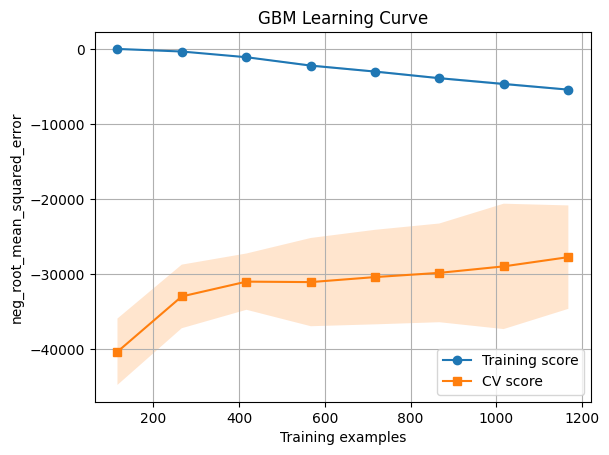

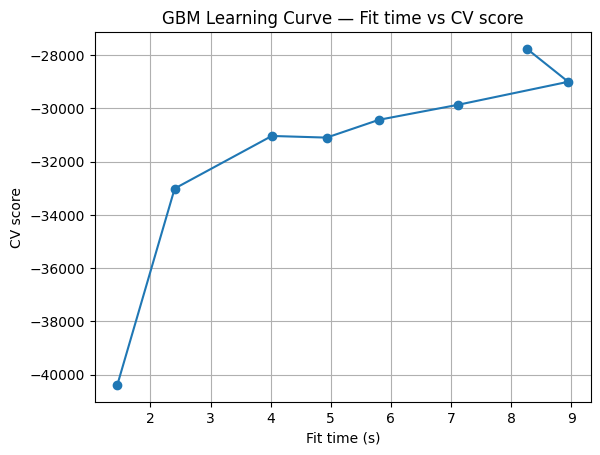

In [199]:
# GBM learning curve
plot_learning_curve(
    estimator=gbm_grid.best_estimator_,
    X=X, y=y,
    cv=cv,                               # reuse the same splitter you used in GridSearchCV
    scoring="neg_root_mean_squared_error",
    shuffle=False,                        # set True only if your CV splitter allows shuffling
    n_jobs=-1,
    title="GBM Learning Curve"
)

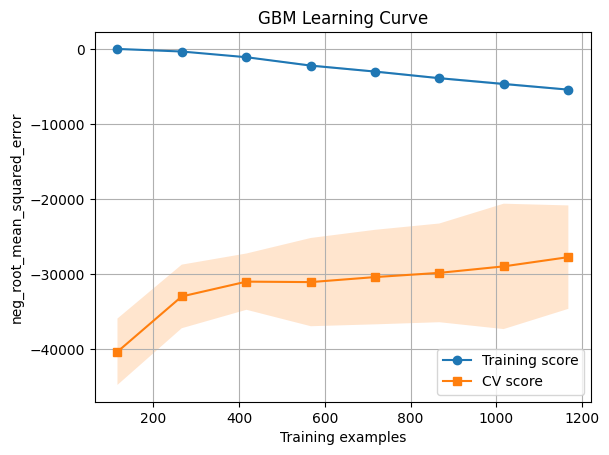

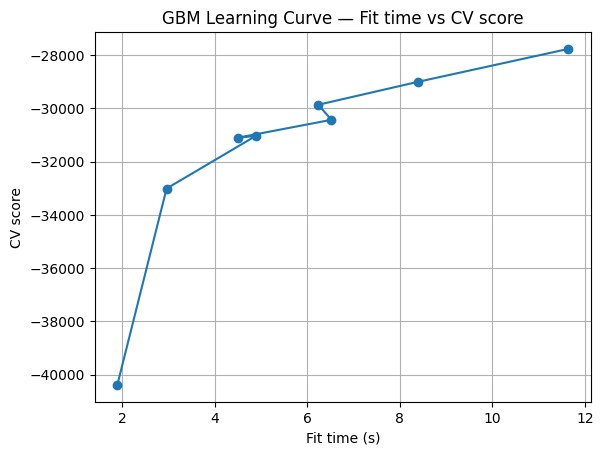

In [200]:
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

plot_learning_curve(
    estimator=gbm_grid.best_estimator_,
    X=X, y=y,
    cv=cv5,                               # reuse the same splitter you used in GridSearchCV
    scoring="neg_root_mean_squared_error",
    shuffle=False,                        # set True only if your CV splitter allows shuffling
    n_jobs=-1,
    title="GBM Learning Curve"
)

Fitting 15 folds for each of 1458 candidates, totalling 21870 fits
Best RMSE: -27829.71820952623
Best params: {'regressor__model__learning_rate': 0.08, 'regressor__model__max_depth': 3, 'regressor__model__max_features': 0.4, 'regressor__model__min_samples_leaf': 5, 'regressor__model__n_estimators': 800, 'regressor__model__subsample': 0.6, 'regressor__preprocess__features__nominal__collapse__threshold': 10}


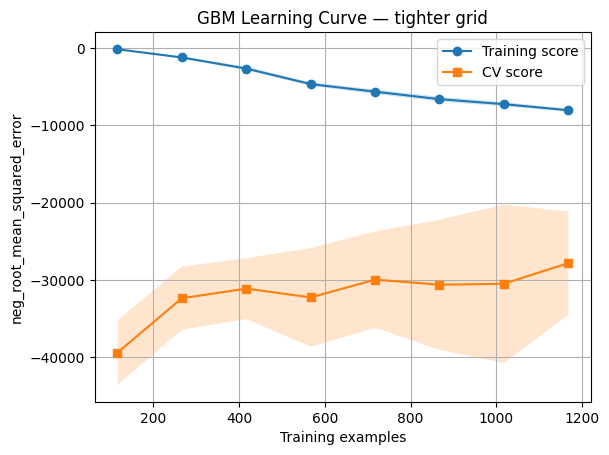

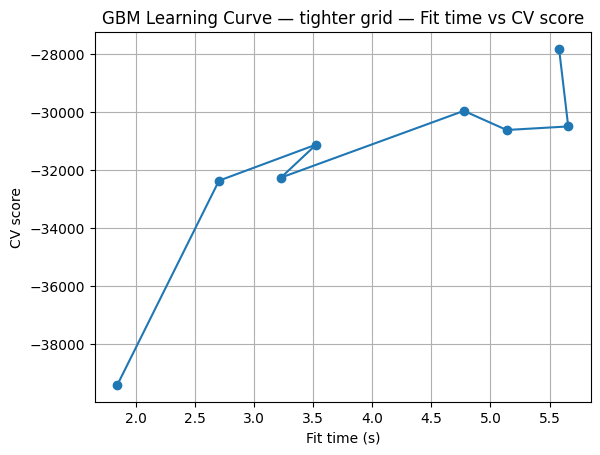

In [201]:
gbm_tighter = {
    'regressor__model__max_depth': [3, 4],
    'regressor__model__min_samples_leaf': [5, 10, 20],
    'regressor__model__max_features': [0.4, 0.6, 'sqrt'],   # float = fraction of features
    'regressor__model__subsample': [0.6, 0.7, 0.8],
    'regressor__model__n_estimators': [400, 600, 800],
    'regressor__model__learning_rate': [0.03, 0.05, 0.08],
    'regressor__preprocess__features__nominal__collapse__threshold': [10, 20, 40],
}

gbm_grid_tighter = GridSearchCV(
    estimator=gbm_est,   # your pipeline: preprocess -> model
    param_grid=gbm_tighter,
    scoring='neg_root_mean_squared_error',
    cv=cv5,               # your chosen splitter
    n_jobs=-1,
    verbose=1,
    refit=True           # default; ensures best_estimator_ is refit on full data
)

gbm_grid_tighter.fit(X, y)
print("Best RMSE:", gbm_grid_tighter.best_score_)
print("Best params:", gbm_grid_tighter.best_params_)

# Learning curve on the *single best* model (not the whole grid)
plot_learning_curve(
    estimator=gbm_grid_tighter.best_estimator_,
    X=X, y=y,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    shuffle=False,
    n_jobs=-1,
    title="GBM Learning Curve — tighter grid"
)

In [202]:
# 1) Stronger CV (reduces "lucky fold" wins)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

gbm_param_grid_v3 = {
    "regressor__model__max_depth": [2, 3, 4],                # include 2
    "regressor__model__min_samples_leaf": [20, 50, 100, 200],# much larger leaves
    "regressor__model__min_samples_split": [2, 10, 50],      # curb eager splits
    "regressor__model__max_features": [0.4, 0.6, "sqrt"],    # fine
    "regressor__model__subsample": [0.6, 0.7, 0.8],          # fine
    "regressor__model__learning_rate": [0.03, 0.05],         # keep small
    "regressor__model__n_estimators": [800, 1200],           # more trees w/ small LR
    "regressor__preprocess__features__nominal__collapse__threshold": [10, 20, 40],
}

gbm_grid_v3 = GridSearchCV(
    estimator=gbm_est,                  # your pipeline
    param_grid=gbm_param_grid_v3,
    scoring="neg_root_mean_squared_error",
    cv=cv,                              # <- use the repeated CV here
    n_jobs=-1,
    verbose=1,
    refit=True
)

gbm_grid_v3.fit(X, y)
print("Best CV neg-RMSE:", gbm_grid_v3.best_score_)
print("Best params:", gbm_grid_v3.best_params_)
best_gbm = gbm_grid_v3.best_estimator_

Fitting 15 folds for each of 3888 candidates, totalling 58320 fits
Best CV neg-RMSE: -28290.517863545923
Best params: {'regressor__model__learning_rate': 0.05, 'regressor__model__max_depth': 3, 'regressor__model__max_features': 0.4, 'regressor__model__min_samples_leaf': 20, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 1200, 'regressor__model__subsample': 0.8, 'regressor__preprocess__features__nominal__collapse__threshold': 20}


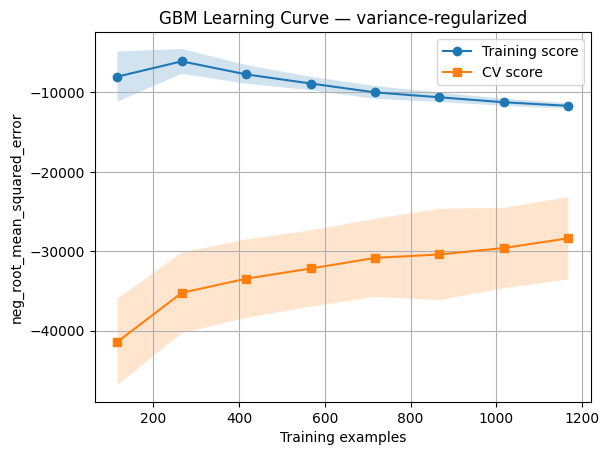

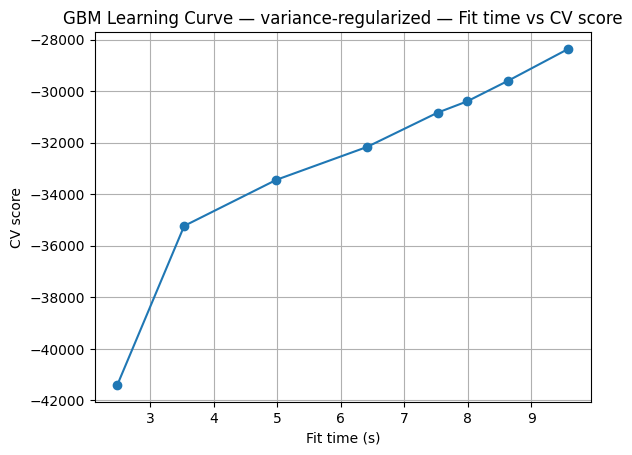

In [203]:
plot_learning_curve(
    estimator=best_gbm,
    X=X, y=y,
    cv=cv,                                     # same object as grid search
    scoring="neg_root_mean_squared_error",
    shuffle=True,
    n_jobs=-1,
    title="GBM Learning Curve — variance-regularized"
)

Fitting 15 folds for each of 972 candidates, totalling 14580 fits
HGBR Best CV neg-RMSE: -30510.539395688957
HGBR Best params: {'regressor__model__l2_regularization': 1.0, 'regressor__model__learning_rate': 0.05, 'regressor__model__max_depth': 2, 'regressor__model__max_leaf_nodes': 15, 'regressor__model__min_samples_leaf': 50, 'regressor__preprocess__features__nominal__collapse__threshold': 40}


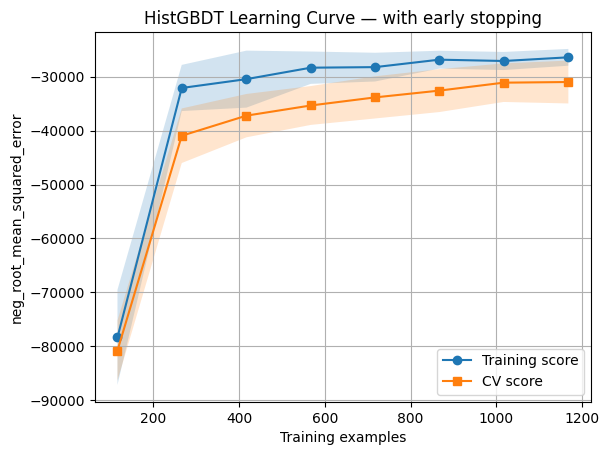

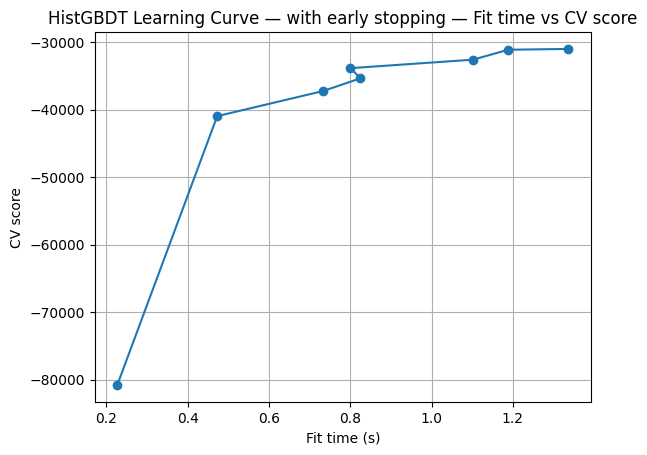

In [204]:
import copy
from sklearn.ensemble import HistGradientBoostingRegressor

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

gbm_est_hgb = copy.deepcopy(gbm_est)
gbm_est_hgb.set_params(
    regressor__model=HistGradientBoostingRegressor(
        random_state=42,
        early_stopping=True,
        validation_fraction=0.15,
        max_iter=3000                      # high cap; ES will stop earlier
    )
)

hgb_param_grid = {
    "regressor__model__learning_rate": [0.03, 0.05, 0.1],
    "regressor__model__max_depth": [2, 3, 4],
    "regressor__model__max_leaf_nodes": [15, 31, 63],
    "regressor__model__min_samples_leaf": [50, 100, 200],
    "regressor__model__l2_regularization": [0.0, 0.5, 1.0, 3.0],
    "regressor__preprocess__features__nominal__collapse__threshold": [10, 20, 40],
}

hgb_grid = GridSearchCV(
    estimator=gbm_est_hgb,
    param_grid=hgb_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

hgb_grid.fit(X, y)
print("HGBR Best CV neg-RMSE:", hgb_grid.best_score_)
print("HGBR Best params:", hgb_grid.best_params_)
best_hgb = hgb_grid.best_estimator_

plot_learning_curve(
    estimator=best_hgb,
    X=X, y=y,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    shuffle=True,
    n_jobs=-1,
    title="HistGBDT Learning Curve — with early stopping"
)

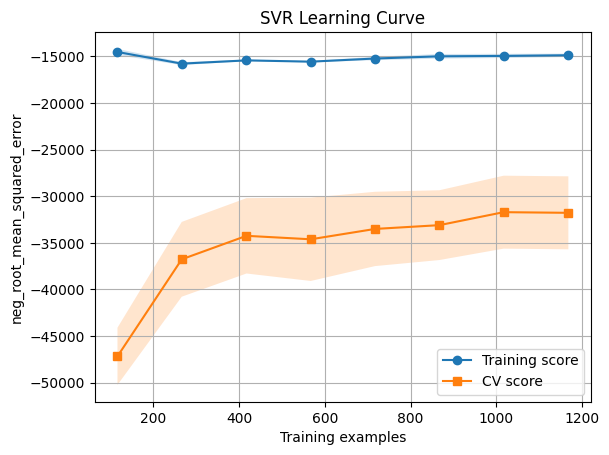

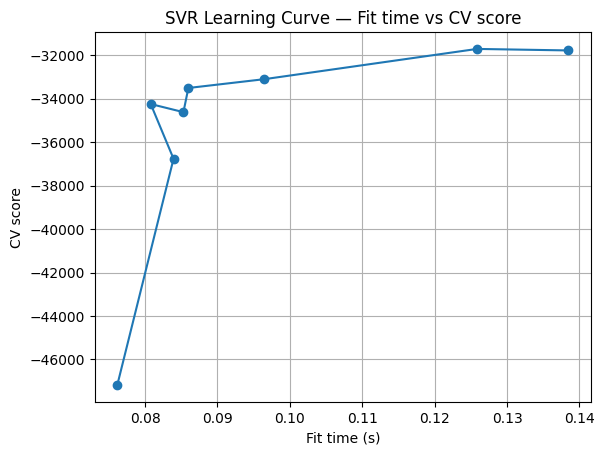

In [191]:
# SVR learning curve
plot_learning_curve(
    estimator=svr_grid.best_estimator_,
    X=X, y=y,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    shuffle=False,
    n_jobs=-1,
    title="SVR Learning Curve"
)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

# You already have this helper:
# def make_model(reg): ... returns TransformedTargetRegressor with
# regressor = Pipeline([('preprocess', preprocessor_pipeline), ('model', reg)])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Build wrapped estimators ---
gbm_est = make_model(GradientBoostingRegressor(random_state=42))
svr_est = make_model(SVR(kernel='rbf'))

# (Optional) Sanity-check the available param names once:
# print(sorted(gbm_est.get_params().keys()))

# =======================
# Param grid: GBM
# =======================
gbm_param_grid = {
    # --- Preprocessing (keep it minimal) ---
    # Your custom rare-category collapse threshold inside the nominal pipeline:
    # CollapseRareCategories(threshold=...)
    'regressor__preprocess__features__nominal__collapse__threshold': [5, 10, 20],

    # If your sklearn supports it, you can try category shrinking via OHE too (small grid).
    # Uncomment ONE of the following (not both) depending on your sklearn version.
    # 'regressor__preprocess__features__nominal__one_hot__min_frequency': [None, 5, 10],
    # 'regressor__preprocess__features__nominal__one_hot__max_categories': [None, 30, 50],

    # --- GBM core hyperparams ---
    'regressor__model__n_estimators':  [300, 600, 1000],
    'regressor__model__learning_rate': [0.05, 0.1, 0.2],
    'regressor__model__max_depth':     [2, 3, 4],
    'regressor__model__min_samples_leaf': [1, 3, 5],
    'regressor__model__subsample':     [1.0, 0.8],      # stochastic GBM can help generalization
    'regressor__model__max_features':  [None, 'sqrt']   # simple, effective choices
}

gbm_grid = GridSearchCV(
    gbm_est,
    param_grid=gbm_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# =======================
# Param grid: SVR
# =======================
svr_param_grid = {
    # --- Preprocessing (same minimal knob) ---
    'regressor__preprocess__features__nominal__collapse__threshold': [5, 10, 20],

    # Optional OHE category shrinking (pick one if supported)
    # 'regressor__preprocess__features__nominal__one_hot__min_frequency': [None, 5, 10],
    # 'regressor__preprocess__features__nominal__one_hot__max_categories': [None, 30, 50],

    # --- SVR hyperparams ---
    'regressor__model__C':      [3, 10, 30, 100],
    'regressor__model__gamma':  ['scale', 0.1, 0.03, 0.01],
    'regressor__model__epsilon':[0.1, 0.2, 0.3],
}

svr_grid = GridSearchCV(
    svr_est,
    param_grid=svr_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# =======================
# Fit searches (run separately)
# =======================
# gbm_grid.fit(X, y)
# print("GBM best RMSE:", -gbm_grid.best_score_)
# print("GBM best params:", gbm_grid.best_params_)

# svr_grid.fit(X, y)
# print("SVR best RMSE:", -svr_grid.best_score_)
# print("SVR best params:", svr_grid.best_params_)

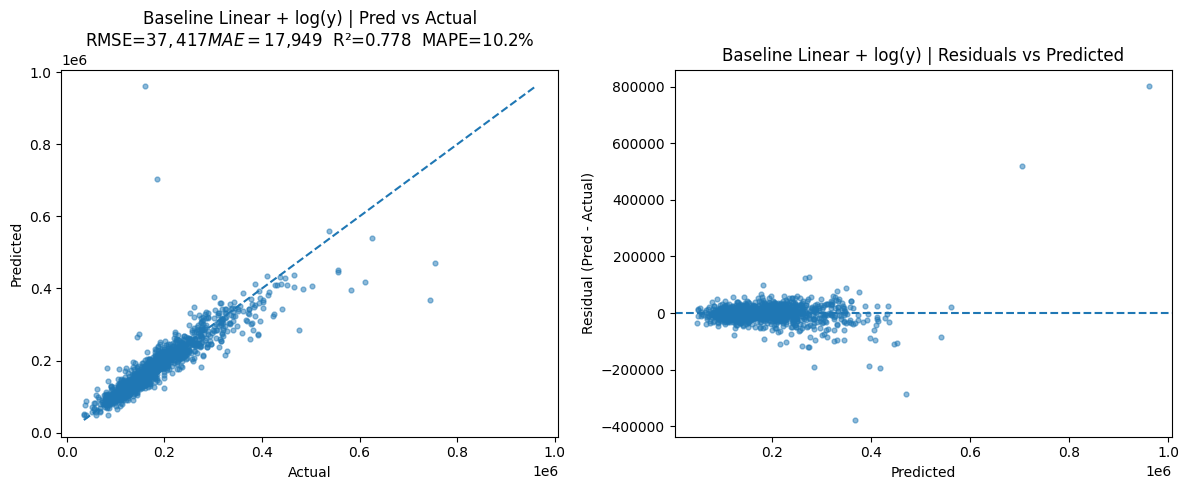

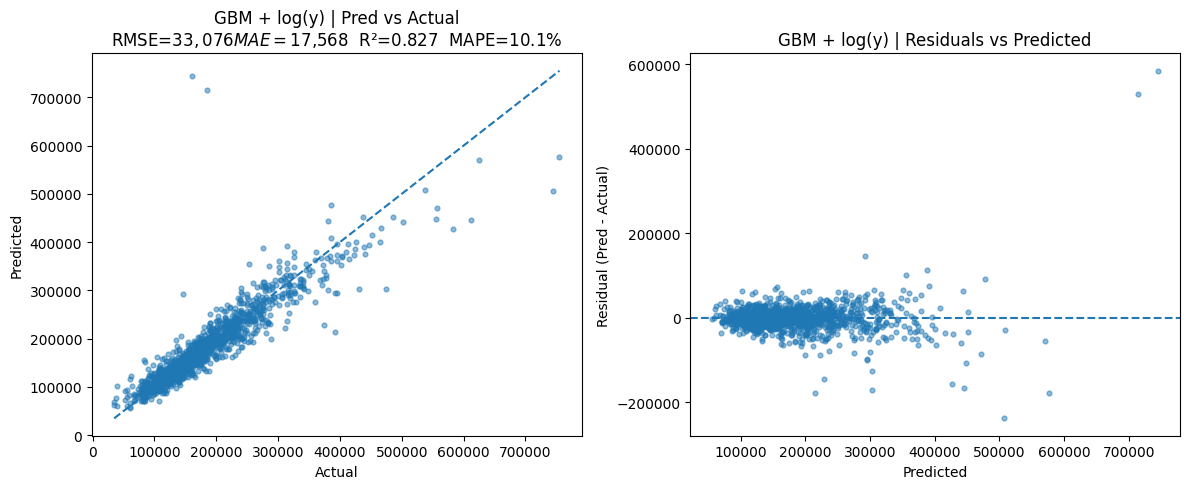

,y_true,y_pred,pct_error
1298,160000,744638.341598,365.398963
523,184750,714779.309562,286.890019
30,40000,102279.132452,155.697831
968,37900,76246.193670,101.177292
1324,147000,292339.736048,98.870569
462,62383,121973.339525,95.523363
410,60000,117016.602154,95.027670
916,35311,68203.436661,93.150680
632,82500,155982.231162,89.069371
1453,84500,152444.440059,80.407621


In [136]:
# ---- helper: out-of-fold predictions (respects your log-target wrapper) ----
def oof_predictions(model, X, y, cv):
    # TTR ensures predictions come back on the original $ scale
    return cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

# ---- helper: quick metrics + diagnostic plots ----
def plot_regression_diagnostics(y_true, y_pred, title="Model"):
    err  = y_pred - y_true
    mae  = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    r2   = 1 - np.sum(err**2) / np.sum((y_true - y_true.mean())**2)
    mape = np.mean(np.abs(err) / y_true) * 100  # %

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1) Predicted vs Actual
    axes[0].scatter(y_true, y_pred, alpha=0.5, s=12)
    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    axes[0].plot([lo, hi], [lo, hi], ls='--')
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title(f"{title} | Pred vs Actual\n"
                      f"RMSE=${rmse:,.0f}  MAE=${mae:,.0f}  R²={r2:.3f}  MAPE={mape:.1f}%")

    # 2) Residuals vs Predicted
    axes[1].scatter(y_pred, err, alpha=0.5, s=12)
    axes[1].axhline(0, ls='--')
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Residual (Pred - Actual)")
    axes[1].set_title(f"{title} | Residuals vs Predicted")

    plt.tight_layout()
    plt.show()

# -------------------------------
# A) Baseline: your existing final_model
# -------------------------------
y_pred_base = oof_predictions(final_model, X, y, cv)
plot_regression_diagnostics(y, y_pred_base, title="Baseline Linear + log(y)")

# -------------------------------
# B) Compare a contender (e.g., GBM) using the SAME preprocessing + log-target
# -------------------------------
def make_model(reg):
    pipe = Pipeline([
        ('preprocess', preprocessor_pipeline),  # (imputer + features)
        ('model', reg)
    ])
    return TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

gbm_model = make_model(GradientBoostingRegressor(random_state=42))
y_pred_gbm = oof_predictions(gbm_model, X, y, cv)
plot_regression_diagnostics(y, y_pred_gbm, title="GBM + log(y)")

# OPTIONAL: inspect a few rows with largest % errors for GBM
comp = pd.DataFrame({'y_true': y, 'y_pred': y_pred_gbm})
comp['pct_error'] = (comp['y_pred'] - comp['y_true']) / comp['y_true'] * 100
comp['abs_pct_error'] = comp['pct_error'].abs()
display(comp.sort_values('abs_pct_error', ascending=False).head(10)[['y_true','y_pred','pct_error']])
